In [33]:
%%time
import manager_dataset as MD
import question_processing as QP
import information_retrieval as IR
import named_entity_recognition as NER
import answer_processing as AP
from gensim.models import KeyedVectors

Wall time: 0 ns


### Settings

Questions recive all the questions treated

In [2]:
questions = MD.questions(treated=True)
incosiderate_classes = ['X', 'MANNER', 'OBJECT', 'OTHER', 'DEFINITION']
questions = QP.remove_incosiderate_classes(questions, incosiderate_classes)  # Question with incosiderate class is removed

The questions that has an answer will be used for test while another questions will be used for train.

In [3]:
train_questions, test_questions = MD.split_questions(questions)

## Question Processing

### Question Classification

Questions to train and test

In [4]:
qc_X_train, qc_y_train = QP.separete_questions(train_questions)

Or Load the Word2Vec model

In [5]:
%%time
w2v_patch = 'data/word_embedding/cbow_s300.txt'
#w2v_patch = 'data/word_embedding/cbow_s50.txt'  # Fast test
w2v = KeyedVectors.load_word2vec_format(w2v_patch, unicode_errors="ignore")
model_w2v = {w: vec for w, vec in zip(w2v.index2word, w2v.syn0)}

Wall time: 3min 38s


And Train a SVM model

In [6]:
%%time
classifier = QP.svm_classifier()
vectorizer = QP.HybridVectorizer(model_w2v)
#vectorizer = QP.MeanEmbeddingVectorizer(model_w2v)
#vectorizer = QP.TfidfHybridVectorizer(model_w2v)
#vectorizer = QP.SequenceHybridVectorizer(model_w2v)
#vectorizer = QP.count_vectorizer(model_w2v)
#vectorizer = QP.tfidf_vectorizer(model_w2v)
model = QP.train_model(qc_X_train, qc_y_train, classifier, vectorizer)

Wall time: 3min 53s


Or Loading the the trained SVM model

In [ ]:
%%time
import dill
model = dill.load(open(QP.answer_type_file, 'rb'))

Answer type is predicted for all questions

In [26]:
questions = QP.predict_answer_type(model, test_questions)

#### Testing

In [8]:
qc_X_test, qc_y_test = QP.separete_questions(test_questions)
print('Size train:',len(qc_y_train),'  Size test:',len(qc_y_test))

Size train: 1694   Size test: 655


Accuracy: 0.906870229008
F1 Score: 0.900186476829


<IPython.core.display.Javascript object>


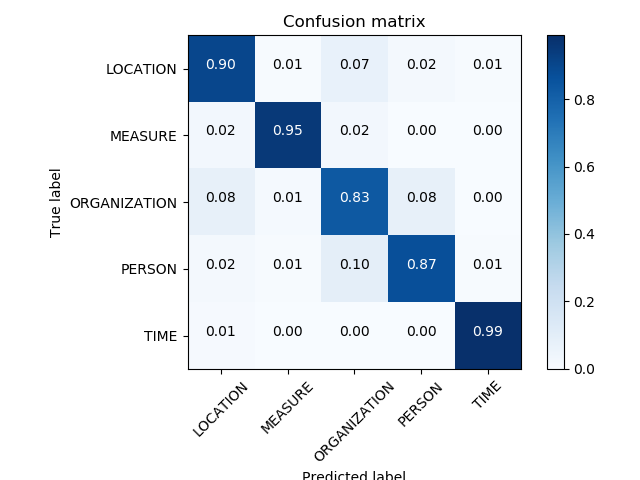

In [9]:
%matplotlib notebook
confusion_matrix = QP.testing(model, qc_X_test, qc_y_test)
QP.plot_confusion_matrix(confusion_matrix, ['LOCATION', 'MEASURE', 'ORGANIZATION', 'PERSON', 'TIME'], normalize=True)

### Query Formulation

All test questions will recive the query for IR module. 

In [10]:
test_questions = QP.queryFormulation(test_questions)

## Information Retrieval

### Document Retrieval

In [11]:
import information_retrieval as IR
ir = IR.InformationRetrieval()

Start the IR module. If the documents was not indexed then they will be.
When reset is True, all indexed documents is removed and indexed again.

In [12]:
ir.start(reset=True)

Indexing:
File: 51511 lines: 
51511/51510
File: 51674 lines: 
51674/51673
File: 51389 lines: 
51389/51388
File: 54708 lines: 
54708/54707
End


In [13]:
%%time
test_questions = ir.retrievalDocuments(test_questions)

Wall time: 6.29 s


#### Testing

In [14]:
import numpy as np

precisions = []
recalls = []
f_scores = []
b = 0.5
for question in test_questions:
    relevants = []
    for answer in question['answers']:
        if answer['doc'] is not None and len(answer['doc']) > 0:
            relevants.append(answer['doc'])
    total_relevants = len(relevants)
    if total_relevants == 0:
        continue
    relevents_retrieval = 0
    for retrieval in question['retrieval']:
        if retrieval in relevants:
            relevents_retrieval += 1
    if len(question['retrieval']) == 0:
           # print(question['query'])
            precision = 0
    else:
        precision = relevents_retrieval / len(question['retrieval'])
    precisions.append(precision)
    recall = relevents_retrieval / total_relevants
    recalls.append(recall)
    if (precision + recall) == 0:
        f_score = 0
    else:
        f_score = 2 * ((precision * recall) / (precision + recall))
    f_scores.append(f_score)

print('Precision: '+str(np.mean(precisions)))
print('Recall: '+str(np.mean(recalls)))
print('F-Score: '+str(np.mean(f_scores)))

Precision: 0.0608490566038
Recall: 0.499859613657
F-Score: 0.10604893511


In [27]:
test_questions[0]

{'answer_candidates': [[('Milão', 'LOCAL-B')],
  [('Itália', 'LOCAL-B')],
  [('Norte,', 'LOCAL-B')],
  [('Itália,', 'LOCAL-B')],
  [('Milão,', 'LOCAL-B')],
  [('Metropolis', 'LOCAL-B'), ('de', 'LOCAL-I'), ('Lang,', 'LOCAL-I')],
  [('Arcore.', 'LOCAL-B')],
  [('Agnelli)', 'LOCAL-B')],
  [('Portofino.', 'LOCAL-B'),
   ('São', 'LOCAL-I'),
   ('a', 'LOCAL-I'),
   ('Milão', 'LOCAL-I')],
  [('Milão,', 'LOCAL-B')],
  [('Piazza', 'LOCAL-B')],
  [('Bocca.', 'LOCAL-B')],
  [('Revue', 'LOCAL-B')],
  [('Itália', 'LOCAL-B')],
  [('Estado)', 'LOCAL-B')],
  [('Liga', 'LOCAL-B')],
  [('Itália', 'LOCAL-B')],
  [('Itália', 'LOCAL-B')],
  [('Milão', 'LOCAL-B')],
  [('Norte', 'LOCAL-B')],
  [('Sul', 'LOCAL-B')],
  [('Itália,', 'LOCAL-B')],
  [('Itália', 'LOCAL-B')],
  [('Piazzale', 'LOCAL-B'), ('Loreto,', 'LOCAL-I')],
  [('Itália', 'LOCAL-B')],
  [('Berlusconi', 'LOCAL-B')],
  [('Norte', 'LOCAL-B')],
  [('Liga', 'LOCAL-B')],
  [('Itália,', 'LOCAL-B')],
  [('Milão,', 'LOCAL-B')],
  [('Berlusconi', 'LOCAL-B

In [ ]:
test_questions[0]['query']

In [ ]:
test_questions[0]['answers']

## Answer Processing

### Named Entity Recognition

In [15]:
import named_entity_recognition as NER

model_ner = NER.train()

#### Testing

In [16]:
NER.predict(model_ner, u'A cidade de Porto Seguro')

[['O', 'O', 'O', 'LOCAL-B', 'LOCAL-I']]

### Answer Extraction

In [17]:
test_questions = AP.answer_candidates(test_questions, QP, ir, NER, model_ner)

[ . . . . . . . . . . ]


### Answer Extraction

In [86]:
test_questions = AP.finals_answer(test_questions)

#### Testing

Check if the answer_candidates have the right answer

In [87]:
AP.test_answer_candidates(test_questions)

655 / 380
Total recall: 58.015 %

Correct answer type:
594 / 357
Recall: 60.101 %


## Final Evaluate

In [88]:
for i in range(len(test_questions)):
    print(test_questions[i]['question'])
    print(test_questions[i]['final_answer'])
    for answer in test_questions[i]['answers']:
        if answer['answer'] is not None:
            print(answer['answer'].strip(), end=' | ')
    print('\n')

Em que cidade se encontra a prisão de San Vittore?
Itália
Milão | 

Onde era o campo de concentração de Auschwitz?
Auschwitz.
Sul da Polónia | Polónia | Sudoeste da Polónia ocupada | 

Quem foi o autor de Mein Kampf?
Hitler
Adolf Hitler | 

Qual é a capital da Rússia?
Ieltsin
Moscovo | 

Quem foi o primeiro presidente dos Estados Unidos?
Adams
George Washington | 

Com quem se casou Michael Jackson?
Lisa Marie
Lisa Marie Presley | 

Quantos crimes são atribuídos ao Monstro de Florença?
16
16 assassinatos | 

Quantos desempregados há na Europa?
0,3 por cento
23 milhões | 

Quantas religiões monoteístas há no mundo?
14
três | 

Nomeie uma pessoa acusada de pedofilia.
Governo
Brendan Smyth | Hans Hermann Groer | 

Quem escreveu Ulisses?
PÚBLICO
James Joyce | 

Onde se situa o CERN?
França
Genebra | 

Em que dia calha o solstício de verão?
século XX
aproximadamente a 21 de Junho | 

Onde fica o Museu do Hermitage?
Portugal
São Petersburgo | 

Qual o nome da mulher de Kurt Cobain?
Kurt Coba

Quando se tornou A Portuguesa hino nacional?
Dezembro
5 de Outubro de 1910 | 

Em que ano ocorreu o 25 de Abril?
28 de Maio de 1926,
1974 | 

Que país é campeão do mundo de futebol?
Brasil
Brasil | 

Onde é que caiu um meteorito em 1908?
Montreal,
Sibéria | Sibéria | 

Quantos capacetes azuis holandeses havia em Srebrenica, na Bósnia, em Julho de 1995?
400
400 | 

Indique um fabricante de automóveis alemão.
Greenpeace
BMW | 

Que partido foi fundado por Andrei Brejnev?
União Soviética
NIL | 

Quem recebeu o Prémio Nobel da Paz em 1989?
Levi-Montalcini
Dalai Lama | Tenzin | Dalai Lama | 

Quem é o primeiro-ministro da Macedónia?
Andreas Papandreou,
Branko Crvenkovski | 

Quem fundou o partido ecologista colombiano Oxigénio?
Presidente
NIL | 

Quando é que o Chipre foi dividido em duas partes?
1974,
1974 | 1974 | 

Desde quando vive o Dalai Lama no exílio?
1959,
1959 | 

Onde é a sede da OMC?
Genebra
Genebra | Genebra | 

Quantas coffee shops existem nos Países-Baixos?
30
2400 | 

Quanta

Quem era o ditador cubano antes da revolução?
Fidel Castro
Fulgencio Batista | Fulgêncio Batista | 

De quem é filha Alina Fernandez Revuelta?
Alina Fernandez Revuelta,
Fidel Castro | Fidel Castro | 

Mencione um lakota.
Wounded Knee
Black Elk | 

Que imperador Marco Polo encontrou em Pequim?
Dalai Lama
Kublai Khan | 

Quem era a amante de Mussolini?
Fini
Clara Petacci | Claretta Petacci | 

Quem escreveu Galileu?
Kepler
Bertolt Brecht | 

Quem escreveu Kieslowski on Kieslowski?
Krzysztof Kieslowski
Danusia Stok | 

Quem foi o primeiro homem em órbita?
Neil Armstrong
Yuri Gagarin | 

Quem é o advogado de Andreotti?
Giulio Andreotti
Odoardo Ascari | 

Quem é o director geral da AIEA?
Pyongyang
Hans Blix | 

Quem é o líder do Partido Popular Italiano?
Silvio Berlusconi
Rocco Buttiglione | 

Quem é o patriarca de Alexandria?
Lawrence Durrell,
Chenuda III | Parthenios III | 

Quem é o prefeito de Lisboa?
Lula
Jorge Sampaio | 

Quem é o presidente da Macedónia?
Gligorov
Kiro Gligorov | Kiro

cerca de novecentos quilómetros a norte dos Açores | Atlântico | 

Onde é que fica a represa Ataturk?
Turquia
Anatólia | 

Qual a capital do Estado Livre de Orange?
Estado Livre de Orange,
Bloemfontein | 

Qual é a cidade santa xiita?
Teerão
Qom | 

Que país tomou a Grande Hanish?
Grande Hanish,
Eritréia | 

Em quanto é que foi multado John Fashanu?
22 para 20
6000 libras esterlinas | 

Em que lugar ficou Paulo de Carvalho no Festival da Eurovisão?
Maria Elisa
último | 

Qual é a duração do filme Heimat?
2
16 horas | 

Qual é a área do Oceano Pacífico?
1 kg
166.241.000 km quadrados | 

Qual é o recorde mundial do salto em altura?
2,40
2,45 m | 

Quanta cerveja bebe um brasileiro anualmente?
50
42 litros | 

Quanto mede Sergei Yuran?
32
1m82 | 

Quanto pesa Romário?
11
70 kg | 

Quantos estados tem o Brasil?
5.000
26 | 27 | 27 | 26 | 

Quantos é que eram os Beatles?
21
quatro | quatro | 

Que percentagem da população do Québec fala francês?
7,2 milhões
82% | 

Que população tem Amiens?


13 de maio de 1888,
13 de maio de 1888 | 

Por quem?
N/A
princesa Isabel | 

Em que ano foi fundada a Bertrand?
80
1732 | 

Quem era a locomotiva humana?
Maria Fumaça
Emil Zátopek | 

Em que concelho fica Loivos do Monte?
Sobral
Baião | 

Quem abriu os Jogos Olímpicos de 1948?
Georges Mendes
Jorge VI | 

Quando nasceu Machado de Assis?
1845
21 de Junho de 1839 | 

Quanto custou a Mars Observer?
11
980 milhões de dólares | 

De que região provêm?
EUA
Lombârdia | 

Quando foi inaugurado o metropolitano de Lisboa?
30 de Junho.
29 de Dezembro de 1959 | 

Quantas estações tem agora?
1999,
44 | 

A que altitude está Miguel Pereira?
46
618 metros | 

Em que instituição estudou?
Econômico.
Faculdade do Largo São Francisco | 

Quando é que ele criou a Emília?
1943,
 | 

Quantos municípios tem o distrito do Porto?
16
18 | 

Quem ganhou a NBA em 1995?
Knicks
Houston Rockets | 

Qual o seu período de gestação de ocapi?
70
421 a 457 dias | 

Qual o seu peso?
10
varia entre 200 e 250 kg | 

Que conc

Brasil
Sena | 

Qual o comprimento do Spree?
6.600 milhões de metros
cerca de 400 km | 

Qual é a capital do Cazaquistão?
Turquia
Astana | 

E a sua maior cidade?
São Paulo
Almaty | 

Quem é o actual presidente da Guatemala?
Arbenz
Óscar Berger | 

Quantas faixas tem a bandeira dos Estados Unidos?
mais 500
13 | 

Quando ocorreu a batalha de Torres Vedras?
Setembro
22 de Dezembro de 1846 | 

Onde é que ela foi queimada?
Acre
Ruão | 

Quando?
N/A
30 de maio de 1431 | 

Que idade tinha ela?
1700
19 anos | 

Desde quando está Fidel Castro no poder?
1959, Fidel
1959 | 

Quando é que ele nasceu?
1980,
13 de Agosto de 1926 | 

Quem é o irmão dele?
FHC
Raúl Castro | 

O que são os forcados?
Harry Wu
grupos amadores de vários homens que numa corrida de touros pegam o touro | 

Quando foi assinado o Tratado de Zamora?
17h00
1143 | 

Quem inventou o forno de microondas?
Encarnação Molina, 62. Ela
Percy Spencer | 

Quem patenteou o primeiro telégrafo sem fios?
Roberto Landell de Moura
Landell de M

In [89]:
total = len(test_questions)
right = 0

cc_total = 0  # Total of question with correct candidates
cc_right = 0

for question in test_questions:
    aux = False
    if question['correct_answers_candidates']:
        aux = True
        cc_total += 1
    for answer in question['answers']:
        if answer['answer'] is not None:
            a1 = answer['answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').strip()
            a2 = question['final_answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').strip()
            if a1 in a2 or a2 in a1:
                question['correct_final_answer'] = True
                right += 1
                if aux:
                    cc_right += 1
                break
print(str(total) + ' / ' + str(right))
print('Accuracy: '+ '%.3f' % ((right/total)*100)+' %')
print('\nCorrect answer candidates:\n' + str(cc_total) + ' / ' + str(cc_right))
print('Accuracy: '+ '%.3f' % ((cc_right/cc_total)*100)+' %')

655 / 103
Accuracy: 15.725 %

Correct answer candidates:
380 / 103
Accuracy: 27.105 %


## Util

### Detailed Question Analysis

In [97]:
question = {
    'question': u'Quem é o presidente do Brasil?',
    'class': 'PERSON'
}

#question = test_questions[4]

print('Question: ' + question['question'])

# Question Classification
QP.predict_answer_type(model, [question])
print('Answer Type: ' + question['predict_class'])

# Query Formulation
QP.queryFormulation([question])
print('Query: ' + question['query'])

# Document Retrieval
ir.retrievalDocuments([question])
print('Number of retrieval documents: ' + str(len(question['retrieval'])))

# Answers Candidates
AP.answer_candidates([question], QP, ir, NER, model_ner, loading=False)
print('Number of answer candidates: ' + str(len(question['answer_candidates'])))

# Final Answer
AP.finals_answer([question])
print('Answer: ' + question['final_answer'])

Question: Quem é o presidente do Brasil?
Answer Type: PERSON
Query: text:Quem text:é text:o text:presidente text:do text:Brasil
Number of retrieval documents: 10
Number of answer candidates: 59
Answer: presidente Fernando Henrique Cardoso


Show documents texts

In [ ]:
for doc_id in question['retrieval']:
    print('\n'+doc_id+'\n'+ir.documentText(doc_id))

Show answers candidates

In [91]:
    for ac in question['answer_candidates']:
        print(ac)

[('Lyndon', 'PESSOA-B'), ('Johnson', 'PESSOA-I')]
[('John', 'PESSOA-B'), ('Kennedy,', 'PESSOA-I')]
[('Lincoln', 'PESSOA-B'), ('Gordon', 'PESSOA-I')]
[('João', 'PESSOA-B'), ('Goulart.', 'PESSOA-I')]
[('Ernesto', 'PESSOA-B'), ('Geisel', 'PESSOA-I')]
[('Emílio', 'PESSOA-B'), ('Garrastazu', 'PESSOA-I'), ('Médici', 'PESSOA-I')]
[('Angola,', 'PESSOA-B')]
[('EUA.', 'PESSOA-B'), ('Robert', 'PESSOA-I')]
[('Jonh', 'PESSOA-B'), ('Kennedy', 'PESSOA-I')]
[('João', 'PESSOA-B'), ('Goulart', 'PESSOA-I')]
[('Jânio', 'PESSOA-B'), ('Quadros,', 'PESSOA-I')]
[('Juracy', 'PESSOA-B'), ('Magalhães', 'PESSOA-I')]
[('Golbery', 'PESSOA-B'), ('do', 'PESSOA-I'), ('Couto', 'PESSOA-I'), ('e', 'PESSOA-I'), ('Silva', 'PESSOA-I')]
[('Geisel,', 'PESSOA-B')]
[('João', 'PESSOA-B'), ('Baptista', 'PESSOA-I'), ('Figueiredo,', 'PESSOA-I')]
[('Presidente', 'PESSOA-B')]
[('EUA:', 'PESSOA-B'), ('Bósnia', 'PESSOA-I')]
[('Presidente', 'PESSOA-B'), ('francês,', 'PESSOA-I'), ('Jacques', 'PESSOA-I'), ('Chirac,', 'PESSOA-I')]
[('Presi

Show most vote answer candidates

In [100]:
import operator
votes = {}
for candidate in question['answer_candidates']:
    answer = ''
    for w in candidate:
        answer += ' ' + w[0]
        answer = answer.strip()

    if answer.lower() not in question['question'].lower():
        if answer not in votes:
            votes[answer] = 0
        votes[answer] += 1
sorted(votes, key=votes.get, reverse=True)

['presidente Fernando Henrique Cardoso',
 'Carlos Menem,',
 'Fórum Econômico Mundial,',
 'Relações Exteriores, Fernando Petrella,',
 'Itamaraty',
 'Brasil. Suspensão',
 'FHC',
 'Buenos Aires O presidente Fernando Henrique Cardoso',
 'Grupo Argentina,',
 'Rafael Blanco Villegas,',
 'Brasil,',
 'Brasil, Alieto Guadagni. Guadagni',
 'Franco Macri,',
 'Antonio Ermírio de Moraes,',
 'Américas. Tenho',
 'Roberto Teixeira da Costa,',
 'Brasil. Paulo Cunha,',
 'Paulo Villares,',
 'Villares: Brasil',
 'Mercosul. Werner Karl Ross,',
 'Edson Vaz Musa, presidente da Rhodia:',
 'Campos Meirelles,',
 'presidente Menem.',
 'Mercosul.',
 'presidente do PSDB, João Pimenta da Veiga,',
 'Presidente diz',
 'CARLOS EDUARDO LINS DA SILVA Enviado',
 'presidente Fernando Henrique',
 'Valenti. Valenti',
 'À Radiobrás,',
 'Boutros Ghali',
 'Guerra Fria.',
 'Plano Cavallo',
 'Carlos Menem',
 'Mercosul,',
 'Ken Saro-Wiwa',
 'Nobel da Paz',
 'Lampreia.',
 'presidente do Congresso, José Sarney',
 'presidente da Rep

{'Adams': 4,
 'Angola,': 1,
 'Bill Clinton': 3,
 'Bill Clinton,': 1,
 'Bill Clinton.': 1,
 'Bob Dole,': 1,
 'Boris Ieltsin, Presidente da Rússia,': 1,
 'Brasil,': 2,
 'Brasil. Houve': 1,
 'Brasil. Nossos': 1,
 'Brasília': 1,
 'Carlos Menem': 1,
 'Christian Chaise': 1,
 'Christopher': 4,
 'Clinton': 1,
 'Clinton. Chirac': 1,
 'Congresso,': 1,
 'Congresso.': 1,
 'Cuba': 2,
 'Cúpula das Américas,': 1,
 'Danny Boy,': 1,
 'David Johnson': 1,
 'Delors': 1,
 'EUA. Robert': 1,
 'EUA: Bósnia': 1,
 'Ejup Ganic. Ganic': 1,
 'Emílio Garrastazu Médici': 1,
 'Ernesto Geisel': 1,
 'Estado Warren Christopher': 1,
 'Estado, Warren Christopher': 1,
 'Estado, Warren Christopher,': 1,
 'Estado-Maior das Forças Armadas,': 1,
 'Estados Unidos,': 1,
 'Estados Unidos.': 2,
 'Fernando Henrique': 1,
 'Fernando Henrique.': 1,
 'Geisel,': 1,
 'Gerry Adams': 1,
 'Getúlio Vargas': 1,
 'Golbery do Couto e Silva': 1,
 'Havana,': 1,
 'Hosokawa. Entretanto,': 1,
 'Israel,': 1,
 'Japão,': 1,
 'John F. Kennedy,': 1,
 'Jo

### Others

In [ ]:
ir.stop()

In [85]:
import importlib
importlib.reload(AP)
#raise IpyExit

<module 'answer_processing' from 'C:\\Users\\Eduardo\\UFRGS\\QA\\qa-chave\\answer_processing.py'>